## Colab Mount Drive


**IMPORTANT**

This colab file suppose you uploaded project file in your drive to can use same file in many session without reuploading to help save internet

otherwise you can upload files manually and modify some code (without mounting)

In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Install Sumo for Linux (Colab)

In [3]:
!sudo add-apt-repository -y ppa:sumo/stable
!sudo apt-get update
!sudo apt-get install -y sumo sumo-tools sumo-doc


Repository: 'deb https://ppa.launchpadcontent.net/sumo/stable/ubuntu/ jammy main'
Description:
SUMO is a highly portable, microscopic traffic simulation package designed to handle large road networks. SUMO is open source, licensed under the EPLv2.
More info: https://launchpad.net/~sumo/+archive/ubuntu/stable
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/sumo-ubuntu-stable-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/sumo-ubuntu-stable-jammy.list
Adding key to /etc/apt/trusted.gpg.d/sumo-ubuntu-stable.gpg with fingerprint 7604B28616B7E70EC0E6D840C32412BB1ADB414B
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://arch

In [4]:
!source ~/.bashrc


In [5]:
!sumo --version


Eclipse SUMO sumo Version 1.23.1
 Build features: Linux-6.8.0-59-generic x86_64 GNU 11.4.0 Release FMI Proj GUI Intl SWIG Eigen GDAL GL2PS
 Copyright (C) 2001-2025 German Aerospace Center (DLR) and others; https://sumo.dlr.de

Eclipse SUMO sumo Version 1.23.1 is part of SUMO.
This program and the accompanying materials
are made available under the terms of the Eclipse Public License v2.0
which accompanies this distribution, and is available at
http://www.eclipse.org/legal/epl-v20.html
This program may also be made available under the following Secondary
Licenses when the conditions for such availability set forth in the Eclipse
Public License 2.0 are satisfied: GNU General Public License, version 2
or later which is available at
https://www.gnu.org/licenses/old-licenses/gpl-2.0-standalone.html
SPDX-License-Identifier: EPL-2.0 OR GPL-2.0-or-later


## Install Packages

In [6]:
!pip install traci
!pip install dotenv
!pip install ray
!pip install ray[rllib]
!pip install colorama
!pip install optuna
!pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.2/277.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.0/277.0 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.6/220.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.0 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.1.1
    Uninstalling gymnasium-1.1.1:
      Successfully uninstalled gymnasium-1.1.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Set Main Pathes

In [7]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False



In [8]:
import platform

if platform.system() == "Linux":
    if is_colab():
      print("Running in Google Colab")
      path_main_folder = "/content/drive/My Drive/study/graduation_project/final/Code/project_files/TrafficManager/TrafficManager/"


else:
    print("Running on Windows")
    path_main_folder = "I:/My Drive/study/graduation_project/final/Code/project_files/TrafficManager/TrafficManager/"


path_data_folder = path_main_folder + "AIST_Cleaned/data3_san_stefano/"#"AIST_Cleaned/data2_mosheerIsmail/",data3_san_stefano
path_cfg = path_data_folder +"cfg.sumocfg"
path_project_folder = path_main_folder + ""



Running in Google Colab


In [9]:
yaml_file = path_project_folder + "config.yaml"
keys_file = path_project_folder + "keys.env"
log_file = "sumo_log.txt"

In [10]:
# prompt: check if file path ok

import os

if os.path.exists(path_main_folder):
  print(f"File exists at: {path_main_folder}")
else:
  print(f"File does not exist at: {path_main_folder}")


File exists at: /content/drive/My Drive/study/graduation_project/final/Code/project_files/TrafficManager/TrafficManager/


## Import Packages

In [11]:
import sys
sys.path.append(path_project_folder)


In [12]:
from Connections import SumoConnection
from Connections.Connection import *
from dotenv import load_dotenv
import os
import traci
import gymnasium as gym
from numpy import inf
import numpy as np
import SumoEnvSingleAgent
from Utils_reporting import *
from Utils_running_singleAgent import *
from rewards import *
from stable_baselines3 import PPO ,DQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import torch
import time
from Callbacks import *
from models.d3qn import D3QNAgent

## Load Parameters

In [15]:
import yaml

# Load YAML file
# if something modified ,just rerun this cell
with open(yaml_file, "r") as file:
    config = yaml.safe_load(file)


In [16]:
general_settings = config['general_settings']
experiment_settings_changable = config["experiment_settings"]['changable_settings']
experiment_settings_const = config["experiment_settings"]["const_settings"]
algorithm_settings=config["algorithms_settings"]

In [17]:
is_gui = general_settings['is_gui']
see_progress_each = general_settings['see_progress_each']
enable_variation_action = general_settings["enable_variation_action"]


In [18]:
# Access specific parameters (Changable Settings)
n_epsiode = experiment_settings_changable["n_epsiode"]
max_sumo_steps = experiment_settings_changable["max_sumo_steps"]
ENV_NAME = experiment_settings_changable["ENV_NAME"]
REWARD_TYPE = experiment_settings_changable["REWARD_TYPE"]
EXPERIMENT_NAME = experiment_settings_changable["EXPERIMENT_NAME"]
precent_scale = experiment_settings_changable["precent_scale"]
seed = experiment_settings_changable["seed"]


In [19]:
# Access specific parameters (Const Settings)
max_steps = experiment_settings_const["max_steps"]
n_env = experiment_settings_const["n_env"]
durations = experiment_settings_const["durations"]
agent_id = experiment_settings_const["agent_id"]


In [20]:
sumo_traffic_scale =  int(10 * precent_scale )


In [21]:
step_size,reduced_durations = gcd_and_reduced(durations)
step_size,reduced_durations

(15, [1, 2, 4, 6])

In [22]:
reward_func = {
'proposed_reward':reward_proposed,
'literature':reward_liter,
'project_reward':reward_proj,
}
env_classes = {
    "HighGroupedSumoEnv": SumoEnvSingleAgent.HighGroupedSumoEnv,
    "GroupedSumoEnv": SumoEnvSingleAgent.GroupedSumoEnv ,
    "SumoEnv": SumoEnvSingleAgent.SumoEnv,
}

## Open Sumo

In [23]:
from dotenv import load_dotenv
load_dotenv(keys_file)

True

In [24]:
if platform.system() == "Linux":
    if is_colab():
        print("Running in Google Colab")
        sumo_home = str(os.getenv("sumo_home_lin"))
        sumo_binary = str(os.getenv("sumo_binary_lin"))
        if is_gui:
            print("GUI not supported on linux")
    else:
      print("Not running in HPC Linux (default linux)")


else:
    print("Running on Windows")
    print("Running in Google Colab")
    sumo_home = str(os.getenv("sumo_home_win"))
    if is_gui:
        sumo_binary = str(os.getenv("sumo_binary_gui_win"))
    else:
        sumo_binary = str(os.getenv("sumo_binary_cli_win"))




Running in Google Colab


In [25]:
cmd=[sumo_binary, "-c", path_cfg ,"--log",log_file, "--verbose", "true","--step-length", str(step_size)]


In [26]:
conn=SumoConnection.SumoConnection(cmd)

No connection found, creating a new connection ❌
 Retrying in 1 seconds


## Load Traffic Lights info

In [27]:
traffic_lights,policies=get_traffic_lights_policies_high_group(durations=durations,agent_ids=[agent_id])


In [28]:
traffic_lights

[(4, '6082411793')]

## Make The Environment

In [29]:
# Just reload if you modified the SumoEnvSingleAgent.py file
import importlib
import SumoEnvSingleAgent
#importlib.reload(Connections.RealConnection)



In [30]:

def create_env(config_):
    args = (traffic_lights[0][1],traffic_lights[0][0], reduced_durations,reward_func[REWARD_TYPE], max_steps, max_sumo_steps,sumo_traffic_scale,enable_variation_action,config_,seed)
    env = env_classes[ENV_NAME](*args)
    env.python_path =sumo_home
    env.data_path = path_data_folder
    env.see_progress_each = see_progress_each
    return env

#from ray.tune.registry import register_env # If used later with rlib
#register_env(ENV_NAME, create_env)



In [31]:
set_global_conn(conn)


In [32]:
get_global_conn()

## DQN

### Load DQN Parameters

In [ ]:
dqn_settings=algorithm_settings['DQN']


In [ ]:
exploration_initial_eps = dqn_settings["exploration_initial_eps"]
exploration_final_eps = dqn_settings["exploration_final_eps"]
exploration_fraction = dqn_settings["exploration_fraction"]
learning_rate = float(dqn_settings["learning_rate"])
gamma = dqn_settings["gamma"]
policy_kwargs = dict(
    net_arch=dqn_settings["policy_kwargs"]["net_arch"],
    activation_fn=torch.nn.ReLU
)
batch_size = dqn_settings['batch_size']

### Prepare DQN

In [ ]:
env = create_env({})  # Create the environment instance

In [ ]:
model = EpsDQN(
    RMS_DQNPolicy,
    env,
    verbose = 1,
    batch_size=batch_size,
    learning_rate=learning_rate,
    gamma=gamma,
    exploration_initial_eps=exploration_initial_eps,  # Initial epsilon value.
    exploration_final_eps=exploration_final_eps,      # Final epsilon value.
    exploration_fraction=exploration_fraction,        # Fraction of total timesteps for linear decay.
    policy_kwargs=policy_kwargs,
    seed=seed
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
callback = Stable_RewardCallback(max_episodes = n_epsiode)

### Train

In [ ]:
time_before = time.time()
model.learn(total_timesteps=1e9, callback=callback)
time_after = time.time()

In [ ]:
# Save the model
# model.save("models/"+EXPERIMENT_NAME)

In [ ]:
rewards = callback.episode_rewards
results_dict = env.last_run_dict # env.env for D3QN ,env for PPO


## PPO

### Hyperparameter Optimizing using Optuna (Only run once)

In [ ]:
import optuna
from colorama import Fore, Style
import torch

n_tune_episode = 10
n_trials = 20
seeds = [0, 1, 2]  # You can change or increase this list

def objective(trial):
    # Sample hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-3)
    gamma = trial.suggest_float('gamma', 0.9, 0.9999)
    gae_lambda = trial.suggest_float('gae_lambda', 0.8, 1.0)
    ent_coef = trial.suggest_float('ent_coef', 0.0, 0.1)
    clip_range = trial.suggest_float('clip_range', 0.1, 0.4)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256, 512])
    net_arch = trial.suggest_categorical('net_arch', [32, 64, 128, 256, 512])

    policy_kwargs = dict(
        net_arch=[net_arch],
        activation_fn=torch.nn.ReLU
    )

    rewards_diffs = []

    for seed in seeds:
        env = create_env({})
        vec_env = DummyVecEnv([lambda: env])
        vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=False)

        model = PPO(
            "MlpPolicy", vec_env,
            learning_rate=learning_rate,
            gamma=gamma,
            gae_lambda=gae_lambda,
            ent_coef=ent_coef,
            clip_range=clip_range,
            batch_size=batch_size,
            verbose=0,
            policy_kwargs=policy_kwargs,
            seed=seed
        )

        callback = Stable_RewardCallback(max_episodes=n_tune_episode)
        model.learn(total_timesteps=int(1e4), callback=callback)  # reduce steps for tuning

        rewards = callback.episode_rewards
        if len(rewards) >= 2:
            rewards_diff = rewards[-1] - rewards[0]
            rewards_diffs.append(rewards_diff)
            print(Fore.BLUE + f"Seed {seed} epsiodes done in trial {trial.number+1}" + Style.RESET_ALL)


    avg_reward_diff = sum(rewards_diffs) / len(rewards_diffs)

    print(Fore.GREEN + f"-------------Trial {trial.number+1} finished, avg reward delta = {avg_reward_diff:.2f}-----------" + Style.RESET_ALL)
    return avg_reward_diff

# Create Optuna study
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=n_trials)

print("Best Hyperparameters:", study.best_params)


[I 2025-05-05 01:10:17,619] A new study created in memory with name: no-name-a7ff6b07-f140-43e6-8e48-4d9441892e81


Successfully ran C:\Program Files (x86)\Eclipse\Sumo\tools\xml\xml2csv.py with I:\My Drive\study\graduation_project\final\Code\project_files\TrafficManager\TrafficManager\AIST_Cleaned\data2_mosheerIsmail\osm.statistics.xml
No connection found, creating a new connection ❌
Environment reset
Progress: 11/500, Sumo Time 510.0, state [  0.    0.  100.    0.    0.5   0.5   0.5], action gggg, duration 6, reward -3.5999999999999996Successfully ran C:\Program Files (x86)\Eclipse\Sumo\tools\xml\xml2csv.py with I:\My Drive\study\graduation_project\final\Code\project_files\TrafficManager\TrafficManager\AIST_Cleaned\data2_mosheerIsmail\osm.statistics.xml
No connection found, creating a new connection ❌
Environment reset
ITERATION 0 FINISHED, with Reward -20.221874609589577
Progress: 11/500, Sumo Time 510.0, state [  0.    0.  100.    0.    0.5   0.5   0.5], action rrrr, duration 6, reward -3.5999999999999996Successfully ran C:\Program Files (x86)\Eclipse\Sumo\tools\xml\xml2csv.py with I:\My Drive\s

[W 2025-05-05 01:10:27,542] Trial 0 failed with parameters: {'learning_rate': 0.0003751655787285152, 'gamma': 0.9949763592103507, 'gae_lambda': 0.9463987883622811, 'ent_coef': 0.05986584841970366, 'clip_range': 0.14680559213273098, 'batch_size': 128, 'net_arch': 64} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\LapStore\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\LapStore\AppData\Local\Temp\ipykernel_7760\1174124141.py", line 45, in objective
    model.learn(total_timesteps=int(1e4), callback=callback)  # reduce steps for tuning
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\LapStore\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\ppo\ppo.py", line 311, in learn
    return super().learn(
           ^^^^^^^^^^^^^^
  File "

KeyboardInterrupt: 

In [ ]:
study.best_params

{'learning_rate': 0.0003751655787285152,
 'gamma': 0.9949763592103507,
 'gae_lambda': 0.9463987883622811,
 'ent_coef': 0.05986584841970366,
 'clip_range': 0.14680559213273098,
 'batch_size': 128,
 'net_arch': 64}

In [ ]:
study.best_value

-0.4377777973810832

### Intialize Enviroment

In [ ]:
env = create_env({})  # Create the environment instance


In [ ]:
vec_env = DummyVecEnv([lambda: env])

# 3. Wrap with VecNormalize
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=False)



In [ ]:
print("Running mean:", vec_env.obs_rms.mean)
print("Running var:", vec_env.obs_rms.var)


Running mean: [0. 0. 0. 0. 0. 0. 0.]
Running var: [1. 1. 1. 1. 1. 1. 1.]


In [ ]:
ppo_Settings = algorithm_settings['PPO']
ppo_experiment_settings =ppo_Settings[str(ENV_NAME+"_"+REWARD_TYPE)]
ppo_experiment_settings

{'learning_rate': 0.00040175764627327305,
 'gamma': 0.92120994593816,
 'gae_lambda': 0.9206969237484213,
 'ent_coef': 0.0963003024066053,
 'clip_range': 0.30509509716122457,
 'batch_size': 512,
 'net_arch': 512}

In [ ]:
ppo_experiment_settings["net_arch"]

512

In [ ]:
policy_kwargs = {
    "net_arch": [ppo_experiment_settings["net_arch"]],
    "activation_fn": torch.nn.ReLU
}

model = PPO(
    "MlpPolicy", vec_env,
    learning_rate=ppo_experiment_settings['learning_rate'],
    gamma=ppo_experiment_settings['gamma'],
    gae_lambda=ppo_experiment_settings['gae_lambda'],
    ent_coef=ppo_experiment_settings['ent_coef'],
    clip_range=ppo_experiment_settings['clip_range'],
    batch_size=ppo_experiment_settings['batch_size'],
    verbose=0,
    policy_kwargs=policy_kwargs,
    seed=seed
)


In [ ]:
callback = Stable_RewardCallback(max_episodes = n_epsiode)

### Begin Training

In [ ]:
time_before = time.time()
model.learn(total_timesteps=1e9, callback=callback)
time_after = time.time()

Successfully ran /usr/share/sumo/tools/xml/xml2csv.py with /content/drive/My Drive/study/graduation_project/final/Code/project_files/TrafficManager/TrafficManager/AIST_Cleaned/data2_mosheerIsmail/osm.statistics.xml
No connection found, creating a new connection ❌
 Retrying in 1 seconds
Environment reset
Progress: 40/2000, Sumo Time 2010.0, state [  0.    0.  100.    0.    0.5   0.5   0.5], action gggg, duration 6, reward -0.6566666666666666Successfully ran /usr/share/sumo/tools/xml/xml2csv.py with /content/drive/My Drive/study/graduation_project/final/Code/project_files/TrafficManager/TrafficManager/AIST_Cleaned/data2_mosheerIsmail/osm.statistics.xml
No connection found, creating a new connection ❌
 Retrying in 1 seconds
Environment reset
ITERATION 0 FINISHED, with Reward -22.87370491027832
Progress: 10/2000, Sumo Time 555.0, state [2.11326516e-02 4.46588962e-04 1.00000000e+02 0.00000000e+00
Progress: 11/2000, Sumo Time 645.0, state [0.00000000e+00 0.00000000e+00 6.50000000e+01 1.22500

In [ ]:
# Save the model
model.save("models/"+EXPERIMENT_NAME+"_test")

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'models' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


In [ ]:
rewards = callback.episode_rewards
results_dict = env.last_run_dict # env.env for D3QN ,env for PPO ##Important should call this before closing env or evaluate


### Evaluate agent

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
evaluate_results= evaluate_policy(model, env, n_eval_episodes=10, return_episode_rewards=False)[0]

## D3QN

### Hyperparameter Optimizing using Optuna (Only run once)

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import NormalizeObservation, NormalizeReward



In [ ]:
env = create_env({})

NameError: name 'create_env' is not defined

In [ ]:
env = NormalizeObservation(env, epsilon=1e-8)


In [ ]:
state_size = env.observation_space.shape
num_actions = env.action_space.n


In [ ]:
import optuna
from colorama import Fore, Style


n_tune_epsiode = 10
n_trials = 20

def objective(trial):
        # Sample hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-3)
    gamma = trial.suggest_float('gamma', 0.9, 0.9999)
    tau = trial.suggest_float('tau', 0.8, 1.0)
    l2_reg = trial.suggest_float('l2_reg', 0.001, 0.01)
    epsilon_decay = trial.suggest_float('epsilon_decay', 0.0001, 0.4)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256, 512])

    reward_diffs = []
    seeds=[0,1,2]
    for seed in seeds:
        agent = D3QNAgent(
            env=env,
            state_size=state_size,
            num_actions=num_actions,
            memory_size=100000,
            batch_size=batch_size,
            gamma=gamma,
            epsilon_start=1.0,
            epsilon_min=0.01,
            epsilon_decay=epsilon_decay,
            learning_rate=learning_rate,
            tau=tau,
            update_freq=4,
            l2_reg=l2_reg,
            random_state=seed
        )


        training_results = agent.train(
            num_episodes=n_tune_epsiode,
            max_steps_per_episode=200,
            num_points_for_average=100,
            log_interval=10
        )

        rewards_diff = training_results['rewards'][-1] - training_results['rewards'][0]
        reward_diffs.append(rewards_diff)
        print(Fore.BLUE + f"Seed {seed} epsiodes done in trial {trial.number+1}" + Style.RESET_ALL)

    avg_reward_diff = np.mean(reward_diffs)
    print(Fore.GREEN + f"Trial {trial.number+1} Finished, avg_derivative: {avg_reward_diff:.2f}" + Style.RESET_ALL)

    return rewards_diff


# Create an Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials)
# Print best hyperparameters
print("Best Hyperparameters:", study.best_params)


In [ ]:
study.best_params

{'learning_rate': 0.00038910910078213,
 'gamma': 0.9028108626829976,
 'tau': 0.9987876098791424,
 'l2_reg': 0.00774645088987834,
 'epsilon_decay': 0.2930399218446447,
 'batch_size': 64}

In [ ]:
study.best_value

12.543750000000003

### Algorithm

In [33]:
env = create_env({})

In [34]:
import gymnasium as gym
from gymnasium.wrappers import NormalizeObservation, NormalizeReward

env = NormalizeObservation(env, epsilon=1e-8)


In [35]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

In [36]:
d3qn_Settings = algorithm_settings['D3QN']
d3qn_experiment_settings =d3qn_Settings[str(ENV_NAME+"_"+REWARD_TYPE)]
d3qn_experiment_settings

{'learning_rate': 0.00021319709090747468,
 'gamma': 0.9711739118011731,
 'tau': 0.9813155222894172,
 'l2_reg': 0.004261057398770192,
 'epsilon_decay': 0.14509979473154655,
 'batch_size': 64}

In [37]:
parameters={'learning_rate': d3qn_experiment_settings['learning_rate'],
 'gamma': d3qn_experiment_settings['gamma'],
 'tau': d3qn_experiment_settings['tau'],
 'l2_reg': d3qn_experiment_settings['l2_reg'],
 'epsilon_decay': d3qn_experiment_settings['epsilon_decay'],
 'batch_size': d3qn_experiment_settings['batch_size']}


In [38]:
import gymnasium as gym
from gymnasium.wrappers import NormalizeObservation, NormalizeReward
import gym as gymo
from models.d3qn import D3QNAgent
tmp_env = gymo.make('MountainCar-v0',new_step_api=True)

agent_ = D3QNAgent(
            env=tmp_env,
            state_size=tmp_env.observation_space.shape,
            num_actions=tmp_env.action_space.n,

        )

Environment observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Environment action space: Discrete(3)
State size provided: (2,)


In [39]:
training_results = agent_.train(
            num_episodes=2,
            max_steps_per_episode=20,
            num_points_for_average=2,
            log_interval=1)

AttributeError: module 'numpy' has no attribute 'bool8'

In [ ]:
path_save = 'models/tmp_unrelated.h5'
agent_.save_model(path_save)


In [40]:
agent_.load_model(path_save)

NameError: name 'path_save' is not defined

In [41]:
agent = D3QNAgent(
            env=env,
            state_size=state_size,
            num_actions=num_actions,
            memory_size=100000,
            batch_size=parameters['batch_size'],
            gamma=parameters['gamma'],
            epsilon_start=1.0,
            epsilon_min=0.01,
            epsilon_decay=parameters['epsilon_decay'],
            learning_rate=parameters['learning_rate'],
            tau=parameters['tau'],
            update_freq=4,
            l2_reg=parameters['l2_reg'],
            random_state=seed
        )




Environment observation space: Box(-inf, inf, (7,), float32)
Environment action space: Discrete(8)
State size provided: (7,)


### Begin Training

In [ ]:
time_before=time.time()
training_results = agent.train(
            num_episodes=n_epsiode,
            max_steps_per_episode=max_steps,
            num_points_for_average=100,
            log_interval=1)
time_after=time.time()

Streaming output truncated to the last 5000 lines.
Progress: 26/2000, Sumo Time 1020.0, state [3.97683193e+00 3.32388578e+01 3.45000000e+01 1.87725000e+03
Progress: 27/2000, Sumo Time 1050.0, state [5.80824340e+00 5.85589659e+01 2.55555556e+01 1.38580247e+03
Progress: 28/2000, Sumo Time 1080.0, state [7.55094912e+00 6.32561510e+01 2.30000000e+01 1.32100000e+03
Progress: 29/2000, Sumo Time 1110.0, state [6.35489362e+00 6.94496339e+01 1.68181818e+01 1.05123967e+03
Progress: 30/2000, Sumo Time 1140.0, state [4.26493516e+00 2.87034297e+01 2.22727273e+01 1.15165289e+03
Progress: 31/2000, Sumo Time 1170.0, state [7.65099711e+00 3.89097965e+01 1.91666667e+01 1.12430556e+03
Progress: 32/2000, Sumo Time 1230.0, state [5.40076876e+00 4.77419226e+01 2.85000000e+01 1.47525000e+03
Progress: 33/2000, Sumo Time 1260.0, state [7.50848080e+00 3.00076902e+01 2.77272727e+01 1.43801653e+03
Progress: 34/2000, Sumo Time 1290.0, state [7.02696501e+00 4.40985597e+01 2.36363636e+01 1.19132231e+03
Progress: 35/

In [57]:
results_dict = env.env.last_run_dict # env.env for D3QN ,env for PPO ##Important should call this before closing env or evaluate


###  Evaluate

In [58]:
evaluate_results=agent.evaluate(num_episodes=10)

Successfully ran /usr/share/sumo/tools/xml/xml2csv.py with /content/drive/My Drive/study/graduation_project/final/Code/project_files/TrafficManager/TrafficManager/AIST_Cleaned/data3_san_stefano/osm.statistics.xml
No connection found, creating a new connection ❌
 Retrying in 1 seconds
Environment reset
Progress: 1/2000, Sumo Time 90.0, state [2.92633797e+00 1.48759542e+01 3.00000000e+00 3.60000000e+01
Progress: 2/2000, Sumo Time 180.0, state [6.74697983e+00 4.66141721e+01 1.62500000e+01 5.17187500e+02
Progress: 3/2000, Sumo Time 210.0, state [9.58555863e+00 5.84199765e+01 2.05000000e+01 4.52250000e+02
Progress: 4/2000, Sumo Time 240.0, state [8.04136636e+00 3.38969895e+01 1.45000000e+01 4.07250000e+02
Progress: 5/2000, Sumo Time 300.0, state [3.10817138e+00 1.83050962e+01 1.83333333e+01 6.72222222e+02
Progress: 6/2000, Sumo Time 330.0, state [2.52296306e+00 6.65719820e+00 2.65000000e+01 1.01025000e+03
Progress: 7/2000, Sumo Time 360.0, state [5.13816077e+00 4.42786644e+01 3.27777778e+01

In [59]:
rewards=training_results['rewards']
losses=training_results['losses']


In [72]:
# Save the trained model
path_save = str(ENV_NAME+'_'+REWARD_TYPE+'_'+EXPERIMENT_NAME)
agent.save_model(path_save+".keras")



In [74]:
from keras.config import enable_unsafe_deserialization
enable_unsafe_deserialization()
agent.load_model(path_save+".keras")


## Save and See results

In [67]:
time_diff = time_after - time_before
print(Fore.GREEN + f"Time taken for training: {round(time_diff,3)} seconds ({round(time_diff/60,3)} Minutes)" + Style.RESET_ALL)


Time taken for training: 2329.37 seconds (38.823 Minutes)


In [62]:
def append_to_file(filename, text):
    with open(filename, 'a') as file:
        file.write(text + '\n')  # '\n' لتضيف السطر الجديد بعد كل جملة


In [64]:
last_cumulative_reward = round(rewards[-1],3)

print(Fore.MAGENTA + f"The Cumulative Reward of last Epsiode is : {last_cumulative_reward} ,Using Reward {REWARD_TYPE} " + Style.RESET_ALL)


The Cumulative Reward of last Epsiode is : 25.058 ,Using Reward proposed_reward 


In [63]:
if 'evaluate_results' in locals():
    print(Fore.CYAN + f"Avg. Reward for evaluated environment: {evaluate_results}" + Style.RESET_ALL)



Avg. Reward for evaluated environment: 25.483961867224014


In [66]:
for key, value in results_dict.items():
    print(Fore.CYAN + f"{key}: {round(value,3)}" + Style.RESET_ALL)
    #append_to_file("output1.txt",f"{key}: {round(value,3)}")



Waiting_Time: 19.44
Speed: 27.47
Waiting_Vehicles: 397.0
TimeLoss: 108.11
Depart_Delay: 342.33


In [65]:
derivative = rewards[-1] - rewards[0]
print(Fore.GREEN + f"Derivative of reward  is {derivative}" + Style.RESET_ALL)


Derivative of reward  is 8.54585889896704


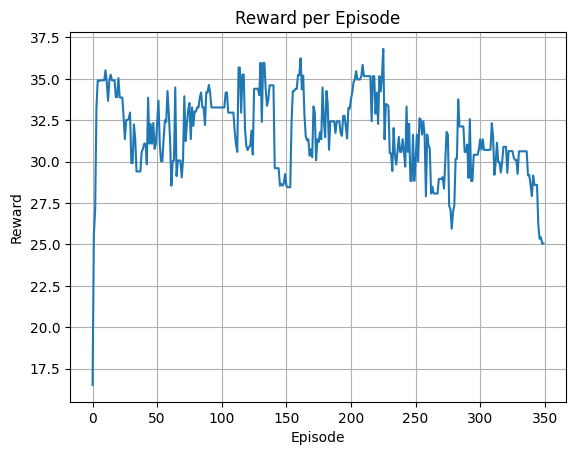

In [69]:
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward per Episode")
plt.grid(True)
plt.show()

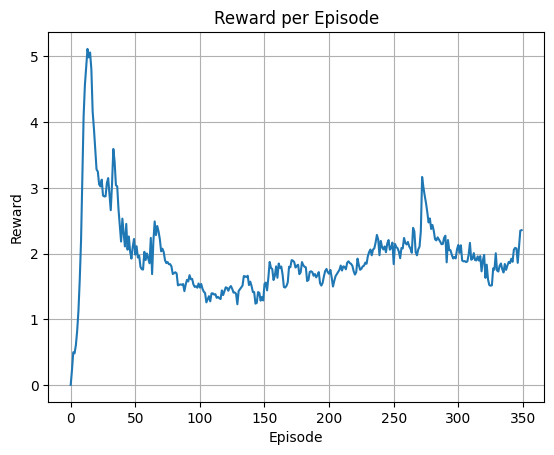

In [68]:
import matplotlib.pyplot as plt
if 'losses' in locals():
    plt.plot(training_results['losses'])
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Loss per Episode")
    plt.grid(True)
    plt.show()

The Following will work with D3QN and give error in PPO

In [70]:
conn.close()
env.close() # Should be closed after all (as last step results)

No active connection to close.
Successfully ran /usr/share/sumo/tools/xml/xml2csv.py with /content/drive/My Drive/study/graduation_project/final/Code/project_files/TrafficManager/TrafficManager/AIST_Cleaned/data3_san_stefano/osm.statistics.xml
Environment close


## ReLoading

In [ ]:
import  Connections.RealConnection
conn2 = Connections.RealConnection.RealConnection()

In [ ]:
set_global_conn(conn2)

In [ ]:
model_loaded = PPO.load("models/temp_test.zip")

In [ ]:
tmp_data = 10* np.random.random((1,7))
random_actions = np.array([1])
random_rewards = np.array([.5])

In [ ]:
model_loaded.rollout_buffer.add(tmp_data,random_actions,random_rewards,random_rewards,random_rewards,np.array([1]))

AttributeError: 'numpy.ndarray' object has no attribute 'clone'

In [ ]:
model_loaded.train(tmp_data)

TypeError: PPO.train() takes 1 positional argument but 2 were given

In [ ]:
model_loaded

In [ ]:
traffic_lights = [(4, '1698478721')]


In [ ]:
sumo_home=''

In [ ]:
env = create_env({})  # Create the environment instance
vec_env = DummyVecEnv([lambda: env])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=False)


env.reset()

Environment reset


(array([0., 0., 0., 0., 0., 0., 0.], dtype=float32), {})

In [ ]:
action, _states = model_loaded.predict(np.array([5]*7), deterministic=True)


In [ ]:
action

array(1, dtype=int64)

In [ ]:
conn2.state={agent_id:np.array([5]*7)}

In [ ]:
int(action)

1

In [ ]:
obs, reward, done,terminated, info = env.step(int(action))

Progress: 1/500, Sumo Time 0, state [5 5 5 5 5 5 5], action rrrr, duration 2, reward 0.0

In [ ]:
reward

0.0

In [ ]:
model_loaded.predict(obs, deterministic=True)

(array(6, dtype=int64), None)

In [ ]:
pip install pyserial


In [ ]:
import serial
import time

# Replace with your actual COM port. For example, '/dev/ttyUSB0' on Linux or 'COM3' on Windows.
arduino = serial.Serial('COM3', 115200 )
time.sleep(2)  # Give Arduino time to reset

# Send 'g' to turn on LED
arduino.write(b'g')

# Optional: close after use
#arduino.close()


1

In [ ]:
arduino.write(b'g')


1

In [ ]:
arduino.close()

In [ ]:
import random
import time
while True:
    s=random.choice([b'g',b'r',b'y'])
    print(f"action {s}")
    arduino.write(s)

    time.sleep(5)

action b'r'
action b'y'
action b'y'
action b'g'
action b'y'
action b'y'
action b'g'
action b'y'
action b'r'
action b'r'
action b'r'
action b'y'
action b'y'
action b'r'
action b'g'


KeyboardInterrupt: 